**FMA - MFCC**

**Team Members**:

*   Francis, Rikky Linuz - UTA ID: 1001753137
*   Mukka, Himaneesh - UTA ID: 1001861524
*   Smitherman, Samuel M - UTA ID: 1000762170

Link of the google colab: https://colab.research.google.com/drive/1knCk7hbeS9riXPXxqSDpsxa_6yLNIDBf?usp=sharing

In [ ]:
import json
import os
import math
import librosa
import librosa.display
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from datetime import datetime
import tensorflow.keras as keras
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings

from google.colab import drive



import numpy as np
import os
from os.path import isfile
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Bidirectional, LSTM, Dropout, Activation, GRU
from keras.layers import Conv2D, concatenate, MaxPooling2D, Flatten, Embedding, Lambda


from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras import backend as K
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop

from keras import regularizers


import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [ ]:
## Path to MFCC of FMA dataset
FMA_DATA_PATH = "/content/drive/MyDrive/FMA-MFCC/data-fma.json"

In [ ]:
## Load the MFCC data from data.json in the given path
def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X,y

In [ ]:
# load data
X,y = load_data(FMA_DATA_PATH)

In [ ]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]
X,y = unison_shuffled_copies(X,y)

In [ ]:
# X = np.array(data["mfcc"])
# y = np.array(data["labels"])

In [ ]:
print(X.shape)
print(y.shape)

(15982, 323, 20)
(15982,)


In [ ]:
# get train, validation, test splits
# create train, validation and test split
X_train_fma, X_test_fma, y_train_fma, y_test_fma = train_test_split(X, y, random_state=42, stratify=y, test_size=0.25)
X_train_fma, X_validation_fma, y_train_fma, y_validation_fma = train_test_split(X_train_fma, y_train_fma, random_state=42, stratify=y_train_fma, test_size=0.25)

In [ ]:
print(X_train_fma.shape)
print(X_validation_fma.shape)
print(X_test_fma.shape)

(8989, 323, 20)
(2997, 323, 20)
(3996, 323, 20)


In [ ]:
batch_size = 32
num_classes = 10
n_features = X_train_fma.shape[2]
n_time = X_train_fma.shape[1]

In [ ]:
nb_filters1=16 
nb_filters2=32 
nb_filters3=64
nb_filters4=64
nb_filters5=64
ksize = (3,1)
pool_size_1= (2,2) 
pool_size_2= (4,4)
pool_size_3 = (4,2)

dropout_prob = 0.20
dense_size1 = 128
lstm_count = 64
num_units = 120

BATCH_SIZE = 64
# make it to 128, filter 64
EPOCH_COUNT = 50
L2_regularization = 0.001

In [ ]:
## Create the model of the layers as per the input shape
def conv_recurrent_model_build(input_shape):
    layer = input_shape
    
    ### Convolutional blocks
    conv_1 = Conv2D(filters = nb_filters1, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_1')(layer)
    pool_1 = MaxPooling2D(pool_size_1)(conv_1)

    conv_2 = Conv2D(filters = nb_filters2, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_2')(conv_1)
    pool_2 = MaxPooling2D(pool_size_1)(conv_2)

    conv_3 = Conv2D(filters = nb_filters3, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_3')(conv_2)
    pool_3 = MaxPooling2D(pool_size_1)(conv_3)
    
    
    conv_4 = Conv2D(filters = nb_filters4, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_4')(conv_3)
    pool_4 = MaxPooling2D(pool_size_2)(conv_4)
    
    
    conv_5 = Conv2D(filters = nb_filters5, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_5')(conv_4)
    pool_5 = MaxPooling2D(pool_size_2)(conv_5)

    flatten1 = Flatten()(pool_5)
    ### Recurrent Block
    
    # Pooling layer
    pool_lstm1 = MaxPooling2D(pool_size_3, name = 'pool_lstm')(layer)
    
    # Embedding layer

    squeezed = Lambda(lambda x: K.squeeze(x, axis= -1))(pool_lstm1)
    
    # Bidirectional GRU
    lstm = Bidirectional(GRU(lstm_count))(squeezed)  #default merge mode is concat
    
    # Concat Output
    concat = concatenate([flatten1, lstm], axis=-1, name ='concat')
    
    ## Softmax Output
    output = Dense(num_classes, activation = 'softmax', name='preds')(concat)
    
    model_output = output
    model = Model(input_shape, model_output)
    
#     opt = Adam(lr=0.001)
    opt = RMSprop(lr=0.00001)  # Optimizer
    model.compile(
            loss='sparse_categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy']
        )
    
    print(model.summary())

    return model

In [ ]:
def train_model(x_train, y_train, x_val, y_val):
    
    n_frequency = 20
    n_frames = 323
    #reshape and expand dims for conv2d
#     x_train = x_train.reshape(-1, n_frequency, n_frames)
    x_train = np.expand_dims(x_train, axis = -1)
    
#     x_val = x_val.reshape(-1, n_frequency, n_frames)
    x_val = np.expand_dims(x_val, axis = -1)
    
    
    input_shape = (n_frames, n_frequency, 1)
    model_input = Input(input_shape, name='input')
    
    model = conv_recurrent_model_build(model_input)
    
#     tb_callback = TensorBoard(log_dir='./logs/4', histogram_freq=1, batch_size=32, write_graph=True, write_grads=False,
#                               write_images=False, embeddings_freq=0, embeddings_layer_names=None,
#                               embeddings_metadata=None)
    checkpoint_callback = ModelCheckpoint('./models/parallel/weights.best.h5', monitor='val_acc', verbose=1,
                                          save_best_only=True, mode='max')
    
    reducelr_callback = ReduceLROnPlateau(
                monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
                verbose=1
            )
    callbacks_list = [checkpoint_callback, reducelr_callback]

    # Fit the model and get training history.
    print('Training...')
    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT,
                        validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list)

    return model, history

In [ ]:
model, history  = train_model(X_train_fma, y_train_fma, X_validation_fma, y_validation_fma)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 323, 20, 1)] 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 321, 20, 16)  64          input[0][0]                      
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 319, 20, 32)  1568        conv_1[0][0]                     
__________________________________________________________________________________________________
conv_3 (Conv2D)                 (None, 317, 20, 64)  6208        conv_2[0][0]                     
______________________________________________________________________________________________

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


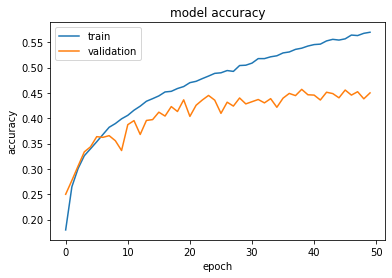

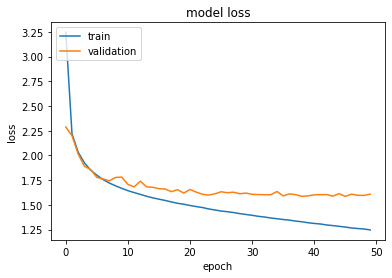

In [ ]:
show_summary_stats(history)

In [ ]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test_fma, y_test_fma, verbose=2)
print('\nTest accuracy:', test_acc)

125/125 - 7s - loss: 1.5869 - accuracy: 0.4474

Test accuracy: 0.44744744896888733


In [ ]:
trackGenreIDs = ['Hip-Hop', 'Hip-Hop', 'Pop', 'Folk', 'Folk', 'Experimental', 'Rock', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Pop', 'Rock', 'Rock', 'Rock', 'Experimental', 'Rock', 'Folk', 'Folk', 'Folk', 'Rock', 'Folk', 'Experimental', 'Folk', 'Folk', 'Folk', 'International', 'International', 'Hip-Hop', 'Rock', 'Hip-Hop', 'Hip-Hop', 'International', 'International', 'International', 'International', 'International', 'International', 'Folk', 'Folk', 'Folk', 'Folk', 'Rock', 'Folk', 'Pop', 'Pop', 'Rock', 'International', 'Folk', 'Folk', 'Experimental', 'Rock', 'Experimental', 'Experimental', 'Experimental', 'Rock', 'Rock', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'International', 'Experimental', 'Rock', 'Rock', 'Folk', 'Folk', 'Folk', 'Folk', 'Experimental', 'Experimental', 'Rock', 'Experimental', 'Experimental', 'Experimental', 'Rock', 'Rock', 'Experimental', 'Electronic', 'Experimental', 'Folk', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Experimental', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Folk', 'Folk', 'Folk', 'Folk', 'Rock', 'Rock', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Rock', 'Rock', 'Folk', 'Folk', 'Folk', 'Experimental', 'Rock', 'Experimental', 'Experimental', 'Folk', 'Pop', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Rock', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Electronic', 'Folk', 'Rock', 'Folk', 'Folk', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'International', 'International', 'International', 'International', 'International', 'Folk', 'Rock', 'Rock', 'Folk', 'International', 'International', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Rock', 'Folk', 'Folk', 'Rock', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Rock', 'International', 'International', 'International', 'International', 'International', 'International', 'Folk', 'International', 'International', 'International', 'International', 'International', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'International', 'International', 'International', 'Rock', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Pop', 'Hip-Hop', 'Hip-Hop', 'Folk', 'Folk', 'Experimental', 'Folk', 'Folk', 'Folk', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Folk', 'Folk', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'International', 'Folk', 'Folk', 'Folk', 'International', 'Rock', 'Rock', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Folk', 'Rock', 'Rock', 'Folk', 'Folk', 'Folk', 'Rock', 'International', 'International', 'Folk', 'Folk', 'Folk', 'Folk', 'Electronic', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Rock', 'Pop', 'Pop', 'Pop', 'Pop', 'Experimental', 'Experimental', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Rock', 'Rock', 'Rock', 'Folk', 'Folk', 'Folk', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Rock', 'Experimental', 'Rock', 'International', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Experimental', 'Experimental', 'Experimental', 'Folk', 'Folk', 'Experimental', 'Rock', 'International', 'Hip-Hop', 'Instrumental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Experimental', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Folk', 'Folk', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Folk', 'Folk', 'Folk', 'Folk', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Experimental', 'Folk', 'Folk', 'Experimental', 'Experimental', 'Folk', 'Pop', 'Pop', 'Pop', 'Hip-Hop', 'Electronic', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Pop', 'Electronic', 'Rock', 'Rock', 'Hip-Hop', 'Hip-Hop', 'Rock', 'Experimental', 'Experimental', 'Folk', 'Folk', 'Folk', 'Folk', 'Experimental', 'Instrumental', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Rock', 'Pop', 'Electronic', 'Experimental', 'Experimental', 'Experimental', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'International', 'Pop', 'Pop', 'Hip-Hop', 'Hip-Hop', 'Pop', 'Pop', 'Electronic', 'Experimental', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Pop', 'Pop', 'Pop', 'Hip-Hop', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Pop', 'Rock', 'Hip-Hop', 'Pop', 'Pop', 'Hip-Hop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'International', 'International', 'International', 'Experimental', 'Folk', 'Folk', 'Pop', 'Pop', 'Hip-Hop', 'Hip-Hop', 'Pop', 'Pop', 'Rock', 'Pop', 'Pop', 'Pop', 'Electronic', 'International', 'International', 'International', 'International', 'Rock', 'Hip-Hop', 'Electronic', 'Hip-Hop', 'Electronic', 'Experimental', 'Hip-Hop', 'Rock', 'Rock', 'Electronic', 'Hip-Hop', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Folk', 'Folk', 'Folk', 'Folk', 'Electronic', 'Electronic', 'International', 'International', 'International', 'International', 'International', 'International', 'Electronic', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'International', 'International', 'International', 'International', 'Rock', 'Folk', 'Pop', 'Folk', 'Experimental', 'Folk', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Folk', 'Electronic', 'Experimental', 'Hip-Hop', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'International', 'International', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'International', 'Pop', 'Pop', 'Pop', 'Hip-Hop', 'Pop', 'International', 'Pop', 'Pop', 'Pop', 'Pop', 'Rock', 'International', 'International', 'International', 'International', 'Rock', 'Rock', 'Rock', 'Rock', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Pop', 'Rock', 'Rock', 'Rock', 'Folk', 'Pop', 'Pop', 'Rock', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Experimental', 'Electronic', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Experimental', 'Rock', 'Hip-Hop', 'Electronic', 'Pop', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Experimental', 'Experimental', 'Pop', 'Pop', 'Pop', 'Folk', 'Rock', 'Folk', 'Rock', 'Rock', 'Experimental', 'Experimental', 'Rock', 'Pop', 'Pop', 'Rock', 'Rock', 'Rock', 'Experimental', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Hip-Hop', 'Hip-Hop', 'Pop', 'Pop', 'International', 'International', 'International', 'Rock', 'Pop', 'Folk', 'Folk', 'Hip-Hop', 'Pop', 'Pop', 'Pop', 'International', 'International', 'International', 'Rock', 'Experimental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Experimental', 'International', 'Hip-Hop', 'Electronic', 'Pop', 'Experimental', 'Experimental', 'Electronic', 'Folk', 'Electronic', 'Hip-Hop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Electronic', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Folk', 'Experimental', 'Electronic', 'Rock', 'Rock', 'Electronic', 'Electronic', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Hip-Hop', 'Hip-Hop', 'Rock', 'Hip-Hop', 'Electronic', 'Pop', 'Experimental', 'Hip-Hop', 'Hip-Hop', 'International', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Electronic', 'Electronic', 'Folk', 'Folk', 'Electronic', 'Rock', 'Pop', 'Rock', 'Experimental', 'International', 'International', 'Rock', 'Experimental', 'Electronic', 'Electronic', 'Folk', 'Electronic', 'Electronic', 'Electronic', 'Experimental', 'Experimental', 'Experimental', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'International', 'International', 'International', 'International', 'International', 'International', 'Pop', 'Experimental', 'Electronic', 'Pop', 'Pop', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Experimental', 'Electronic', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Pop', 'Pop', 'Pop', 'Experimental', 'Folk', 'Experimental', 'Experimental', 'Folk', 'Folk', 'Folk', 'Experimental', 'Experimental', 'Experimental', 'Electronic', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Rock', 'Rock', 'Pop', 'Pop', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Pop', 'Electronic', 'International', 'International', 'International', 'International', 'Folk', 'Electronic', 'Experimental', 'Experimental', 'Experimental', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'International', 'International', 'International', 'International', 'International', 'Electronic', 'Electronic', 'Pop', 'Electronic', 'Hip-Hop', 'Pop', 'Experimental', 'Folk', 'Pop', 'Folk', 'Folk', 'Experimental', 'Experimental', 'International', 'International', 'International', 'International', 'International', 'Rock', 'Rock', 'Electronic', 'Experimental', 'Rock', 'Rock', 'Rock', 'Experimental', 'Experimental', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Electronic', 'Electronic', 'Electronic', 'Experimental', 'Pop', 'Rock', 'Pop', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Experimental', 'International', 'International', 'International', 'Experimental', 'Folk', 'Electronic', 'Electronic', 'Electronic', 'Hip-Hop', 'Hip-Hop', 'Electronic', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Rock', 'Rock', 'Electronic', 'Hip-Hop', 'Folk', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Experimental', 'Experimental', 'Experimental', 'Instrumental', 'Experimental', 'Hip-Hop', 'Experimental', 'Pop', 'Pop', 'Pop', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'International', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Electronic', 'Folk', 'International', 'International', 'International', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Electronic', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Pop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Folk', 'Pop', 'Pop', 'Folk', 'Hip-Hop', 'Rock', 'Folk', 'Folk', 'Electronic', 'International', 'International', 'International', 'International', 'International', 'International', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Experimental', 'International', 'International', 'International', 'International', 'Folk', 'Rock', 'Rock', 'Rock', 'Rock', 'Experimental', 'Experimental', 'Rock', 'Rock', 'Experimental', 'Folk', 'Hip-Hop', 'Experimental', 'Experimental', 'Experimental', 'Folk', 'Experimental', 'Pop', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Pop', 'Pop', 'Experimental', 'Experimental', 'Experimental', 'Electronic', 'Electronic', 'Folk', 'Experimental', 'Experimental', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Pop', 'Pop', 'Pop', 'Pop', 'Electronic', 'Rock', 'Pop', 'Folk', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'International', 'International', 'International', 'International', 'Hip-Hop', 'Hip-Hop', 'Folk', 'Folk', 'Pop', 'Electronic', 'Pop', 'Electronic', 'Electronic', 'Rock', 'Rock', 'Pop', 'Experimental', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Electronic', 'Experimental', 'Pop', 'Pop', 'Pop', 'Pop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Electronic', 'International', 'Experimental', 'Instrumental', 'Instrumental', 'Instrumental', 'Experimental', 'Electronic', 'Pop', 'Instrumental', 'Rock', 'Pop', 'Pop', 'Pop', 'Pop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Experimental', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Experimental', 'Experimental', 'Experimental', 'Rock', 'Instrumental', 'Electronic', 'Experimental', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Folk', 'Folk', 'Folk', 'International', 'Folk', 'Rock', 'Experimental', 'Rock', 'Rock', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Experimental', 'Experimental', 'Electronic', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Pop', 'Pop', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Electronic', 'Rock', 'Experimental', 'Experimental', 'Experimental', 'International', 'Rock', 'Experimental', 'Experimental', 'Folk', 'Pop', 'Electronic', 'Electronic', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Rock', 'Rock', 'Rock', 'Rock', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Instrumental', 'Experimental', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Experimental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Rock', 'Experimental', 'Experimental', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'International', 'International', 'International', 'Experimental', 'Rock', 'Electronic', 'Folk', 'Folk', 'Folk', 'Pop', 'Pop', 'Folk', 'Instrumental', 'Experimental', 'Experimental', 'Experimental', 'Rock', 'Pop', 'Pop', 'Pop', 'Rock', 'Rock', 'Rock', 'Instrumental', 'Instrumental', 'International', 'International', 'International', 'Electronic', 'Electronic', 'International', 'International', 'International', 'International', 'International', 'International', 'Hip-Hop', 'Rock', 'Hip-Hop', 'Hip-Hop', 'Pop', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Rock', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Rock', 'Folk', 'Rock', 'Folk', 'Folk', 'Pop', 'Rock', 'Rock', 'Rock', 'Rock', 'Pop', 'Pop', 'Pop', 'Experimental', 'Experimental', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Experimental', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Experimental', 'Folk', 'Folk', 'Experimental', 'International', 'International', 'International', 'International', 'International', 'Folk', 'International', 'International', 'International', 'International', 'Pop', 'Folk', 'Folk', 'Folk', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Experimental', 'Experimental', 'Hip-Hop', 'Hip-Hop', 'Folk', 'Folk', 'Electronic', 'Experimental', 'Experimental', 'Hip-Hop', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Folk', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Pop', 'Pop', 'Pop', 'International', 'International', 'International', 'International', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Rock', 'Rock', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Rock', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Pop', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Rock', 'Rock', 'Electronic', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Experimental', 'Experimental', 'Rock', 'Experimental', 'Experimental', 'Experimental', 'Hip-Hop', 'Experimental', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Instrumental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Hip-Hop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Rock', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Pop', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Electronic', 'Rock', 'Folk', 'Rock', 'Rock', 'Folk', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Folk', 'Folk', 'Folk', 'Pop', 'Pop', 'Pop', 'Pop', 'Experimental', 'Experimental', 'Pop', 'Folk', 'Folk', 'Pop', 'Pop', 'Pop', 'Pop', 'Rock', 'Rock', 'Rock', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Electronic', 'Experimental', 'Experimental', 'Rock', 'Rock', 'Rock', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'International', 'International', 'International', 'International', 'International', 'International', 'Rock', 'Folk', 'Folk', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Rock', 'Rock', 'Folk', 'Folk', 'Pop', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Rock', 'Pop', 'Hip-Hop', 'Pop', 'Hip-Hop', 'Hip-Hop', 'Rock', 'Rock', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Hip-Hop', 'Pop', 'Folk', 'International', 'Folk', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Experimental', 'Folk', 'Instrumental', 'Instrumental', 'International', 'International', 'International', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Pop', 'Experimental', 'Experimental', 'Experimental', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Experimental', 'Experimental', 'Folk', 'Experimental', 'Folk', 'Folk', 'Folk', 'Instrumental', 'Electronic', 'Electronic', 'Folk', 'Folk', 'Electronic', 'Electronic', 'International', 'International', 'International', 'International', 'International', 'International', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Experimental', 'Pop', 'Pop', 'Pop', 'Pop', 'Electronic', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Folk', 'Folk', 'Folk', 'Folk', 'Rock', 'Hip-Hop', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Pop', 'Pop', 'International', 'International', 'International', 'International', 'Hip-Hop', 'Hip-Hop', 'Electronic', 'Electronic', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Pop', 'Pop', 'Experimental', 'International', 'International', 'International', 'International', 'International', 'International', 'Experimental', 'Rock', 'Electronic', 'Electronic', 'Pop', 'Experimental', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Folk', 'Folk', 'Folk', 'Folk', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Rock', 'Pop', 'Pop', 'Pop', 'Pop', 'Folk', 'Electronic', 'Hip-Hop', 'Hip-Hop', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Experimental', 'Experimental', 'International', 'International', 'International', 'International', 'International', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Electronic', 'Pop', 'Pop', 'Pop', 'Pop', 'Folk', 'Electronic', 'Rock', 'Hip-Hop', 'Electronic', 'Rock', 'Pop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Electronic', 'Electronic', 'Electronic', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Rock', 'Pop', 'Pop', 'Pop', 'Experimental', 'Experimental', 'Hip-Hop', 'Hip-Hop', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Hip-Hop', 'Experimental', 'Experimental', 'Experimental', 'Electronic', 'Electronic', 'International', 'Experimental', 'Experimental', 'Electronic', 'Electronic', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Electronic', 'Rock', 'Rock', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Experimental', 'Pop', 'Rock', 'Pop', 'Folk', 'Folk', 'Folk', 'Folk', 'Pop', 'Pop', 'Pop', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Instrumental', 'Electronic', 'Instrumental', 'Pop', 'Pop', 'Pop', 'Experimental', 'Experimental', 'Rock', 'Electronic', 'Rock', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Folk', 'Folk', 'Folk', 'Rock', 'Rock', 'Rock', 'Rock', 'International', 'International', 'International', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Rock', 'Rock', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Rock', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Pop', 'Pop', 'Pop', 'Folk', 'Folk', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Rock', 'Rock', 'Rock', 'Rock', 'Electronic', 'Pop', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Rock', 'Rock', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Experimental', 'Rock', 'Experimental', 'International', 'International', 'International', 'International', 'International', 'International', 'Experimental', 'International', 'International', 'International', 'International', 'Folk', 'Experimental', 'Experimental', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Rock', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Experimental', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Rock', 'Rock', 'Rock', 'Pop', 'Pop', 'Pop', 'Pop', 'Hip-Hop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Rock', 'Rock', 'Rock', 'Hip-Hop', 'Hip-Hop', 'Instrumental', 'Instrumental', 'Instrumental', 'Pop', 'Pop', 'Pop', 'Instrumental', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Rock', 'Folk', 'Pop', 'Rock', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Rock', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Rock', 'International', 'International', 'International', 'International', 'International', 'International', 'Rock', 'Electronic', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Rock', 'Rock', 'Rock', 'Electronic', 'Electronic', 'Rock', 'Experimental', 'Experimental', 'Experimental', 'Rock', 'Folk', 'Pop', 'Pop', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Folk', 'Folk', 'Rock', 'Rock', 'Rock', 'Experimental', 'Electronic', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Rock', 'Experimental', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Rock', 'Experimental', 'Pop', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Hip-Hop', 'Pop', 'Pop', 'Pop', 'International', 'International', 'International', 'International', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Folk', 'Folk', 'Rock', 'International', 'International', 'International', 'International', 'Experimental', 'Experimental', 'Experimental', 'Electronic', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Rock', 'Pop', 'Pop', 'Pop', 'Pop', 'Folk', 'Pop', 'Pop', 'Pop', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Rock', 'Rock', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'International', 'International', 'Experimental', 'Experimental', 'Experimental', 'Electronic', 'Rock', 'Folk', 'Folk', 'Hip-Hop', 'Hip-Hop', 'Pop', 'Pop', 'Electronic', 'Electronic', 'Electronic', 'Folk', 'Folk', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Folk', 'Folk', 'Electronic', 'Rock', 'Rock', 'Experimental', 'Experimental', 'Experimental', 'Instrumental', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Electronic', 'Electronic', 'Electronic', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Electronic', 'Electronic', 'Rock', 'Instrumental', 'Pop', 'Pop', 'Pop', 'Pop', 'Folk', 'Folk', 'Folk', 'Rock', 'Rock', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Rock', 'Electronic', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Rock', 'Experimental', 'Electronic', 'Experimental', 'Electronic', 'Rock', 'Rock', 'Rock', 'Folk', 'Folk', 'Folk', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Rock', 'Rock', 'Rock', 'Experimental', 'Pop', 'Folk', 'Folk', 'Folk', 'Folk', 'Hip-Hop', 'Hip-Hop', 'Experimental', 'Pop', 'Pop', 'Pop', 'Pop', 'Rock', 'Experimental', 'Experimental', 'Electronic', 'Hip-Hop', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Electronic', 'Electronic', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Electronic', 'Electronic', 'Electronic', 'Rock', 'Rock', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Experimental', 'Experimental', 'Experimental', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Rock', 'Experimental', 'Experimental', 'Electronic', 'Pop', 'Pop', 'Pop', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Experimental', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Folk', 'Experimental', 'Rock', 'Rock', 'Rock', 'Electronic', 'Pop', 'Pop', 'Pop', 'Pop', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Rock', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Rock', 'Rock', 'Electronic', 'Experimental', 'Experimental', 'Experimental', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Rock', 'Rock', 'Rock', 'Pop', 'Pop', 'Pop', 'Pop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Rock', 'Pop', 'Pop', 'Pop', 'Pop', 'Electronic', 'Folk', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Rock', 'Rock', 'Rock', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Pop', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Folk', 'Electronic', 'Experimental', 'Experimental', 'Rock', 'Rock', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Rock', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Experimental', 'Experimental', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Hip-Hop', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Hip-Hop', 'Pop', 'Electronic', 'Rock', 'Pop', 'Folk', 'Folk', 'Folk', 'Electronic', 'Folk', 'Folk', 'Folk', 'Rock', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Pop', 'Experimental', 'Experimental', 'Electronic', 'Electronic', 'Electronic', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Rock', 'Experimental', 'Instrumental', 'Rock', 'Rock', 'Rock', 'Rock', 'Hip-Hop', 'Hip-Hop', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Pop', 'Folk', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Pop', 'Pop', 'Experimental', 'Experimental', 'Rock', 'Electronic', 'Electronic', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Folk', 'Folk', 'Folk', 'Rock', 'Rock', 'Rock', 'Rock', 'Folk', 'Folk', 'Pop', 'Hip-Hop', 'Hip-Hop', 'Experimental', 'Experimental', 'Pop', 'Rock', 'Rock', 'Rock', 'Folk', 'Pop', 'Pop', 'Pop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Pop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Electronic', 'Electronic', 'Electronic', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Rock', 'Rock', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Experimental', 'Experimental', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Rock', 'Pop', 'Pop', 'Pop', 'Pop', 'Instrumental', 'Experimental', 'Experimental', 'Folk', 'Folk', 'Electronic', 'Electronic', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Pop', 'Hip-Hop', 'Pop', 'Electronic', 'Experimental', 'Hip-Hop', 'Folk', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Experimental', 'Rock', 'Folk', 'Electronic', 'Electronic', 'Hip-Hop', 'Hip-Hop', 'Pop', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Rock', 'Hip-Hop', 'International', 'International', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Experimental', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Folk', 'Folk', 'Experimental', 'Folk', 'Folk', 'Folk', 'Folk', 'Experimental', 'Electronic', 'Electronic', 'Electronic', 'Experimental', 'Experimental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Electronic', 'Experimental', 'Folk', 'Folk', 'Folk', 'Instrumental', 'Instrumental', 'Instrumental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Rock', 'Rock', 'Folk', 'Folk', 'International', 'International', 'International', 'International', 'Hip-Hop', 'Hip-Hop', 'Experimental', 'Experimental', 'Experimental', 'Folk', 'Folk', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Folk', 'Folk', 'Folk', 'Folk', 'Pop', 'Pop', 'Pop', 'Pop', 'Hip-Hop', 'Instrumental', 'Instrumental', 'Instrumental', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Rock', 'Rock', 'Rock', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Rock', 'Folk', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Hip-Hop', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Rock', 'Rock', 'Experimental', 'Experimental', 'Experimental', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Pop', 'Instrumental', 'Rock', 'Rock', 'Instrumental', 'Electronic', 'Rock', 'Pop', 'Rock', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Experimental', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Experimental', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Folk', 'Folk', 'Folk', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Experimental', 'Experimental', 'Experimental', 'Pop', 'Pop', 'Pop', 'Pop', 'Experimental', 'Experimental', 'Experimental', 'Rock', 'Rock', 'Hip-Hop', 'Hip-Hop', 'Rock', 'Rock', 'Rock', 'Rock', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Rock', 'Experimental', 'Folk', 'Pop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Rock', 'Rock', 'Rock', 'Rock', 'Electronic', 'Rock', 'Rock', 'Rock', 'Electronic', 'Electronic', 'Electronic', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Electronic', 'Pop', 'Pop', 'Pop', 'Pop', 'Rock', 'Rock', 'Rock', 'Electronic', 'Rock', 'Rock', 'Rock', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Pop', 'Pop', 'Experimental', 'Experimental', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Rock', 'Rock', 'Rock', 'Rock', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Experimental', 'Folk', 'Experimental', 'Folk', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Electronic', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Electronic', 'Rock', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Experimental', 'Experimental', 'Experimental', 'Electronic', 'Experimental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Instrumental', 'Instrumental', 'Instrumental', 'Folk', 'Rock', 'Rock', 'Rock', 'Experimental', 'Pop', 'Pop', 'Pop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Rock', 'Rock', 'Folk', 'Folk', 'Experimental', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Folk', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Rock', 'Folk', 'Folk', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Rock', 'Pop', 'Folk', 'Rock', 'Rock', 'Rock', 'Pop', 'Pop', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Rock', 'Rock', 'Rock', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'International', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'International', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Folk', 'Electronic', 'Electronic', 'Rock', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Experimental', 'Experimental', 'Experimental', 'Rock', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Folk', 'Folk', 'Folk', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Folk', 'Folk', 'Folk', 'Folk', 'Electronic', 'Rock', 'Rock', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Electronic', 'Electronic', 'Pop', 'Pop', 'Pop', 'Rock', 'Rock', 'International', 'Rock', 'Rock', 'Rock', 'Rock', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Rock', 'Rock', 'Rock', 'Rock', 'Electronic', 'Rock', 'Electronic', 'Electronic', 'Electronic', 'Rock', 'Folk', 'Pop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Electronic', 'Experimental', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Instrumental', 'Pop', 'Rock', 'Rock', 'Experimental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'International', 'International', 'International', 'International', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Experimental', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Rock', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'International', 'International', 'International', 'Rock', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Rock', 'Rock', 'Pop', 'Pop', 'Pop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Folk', 'Folk', 'Folk', 'Instrumental', 'Instrumental', 'Instrumental', 'Rock', 'Experimental', 'Experimental', 'Electronic', 'Electronic', 'Experimental', 'Experimental', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Rock', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Rock', 'Rock', 'Rock', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Rock', 'International', 'International', 'International', 'Rock', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Experimental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Rock', 'Rock', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Rock', 'Electronic', 'Electronic', 'Electronic', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Electronic', 'Electronic', 'Experimental', 'Rock', 'Electronic', 'Experimental', 'Electronic', 'Electronic', 'Rock', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Hip-Hop', 'Electronic', 'Electronic', 'Electronic', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Rock', 'Rock', 'Electronic', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'International', 'International', 'International', 'International', 'International', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Rock', 'Experimental', 'Experimental', 'Experimental', 'Rock', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Electronic', 'Hip-Hop', 'Hip-Hop', 'Folk', 'Folk', 'Folk', 'Rock', 'Rock', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Rock', 'Rock', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Folk', 'Folk', 'Experimental', 'Experimental', 'Rock', 'Experimental', 'Experimental', 'Pop', 'Pop', 'Experimental', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Folk', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Rock', 'Hip-Hop', 'Hip-Hop', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Experimental', 'Experimental', 'Experimental', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Folk', 'Folk', 'Rock', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Rock', 'Rock', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Rock', 'Rock', 'Instrumental', 'Experimental', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Instrumental', 'Rock', 'Rock', 'Rock', 'Folk', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Rock', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Rock', 'Rock', 'Rock', 'Rock', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Rock', 'Rock', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Electronic', 'Electronic', 'Electronic', 'Rock', 'Rock', 'Electronic', 'Rock', 'Hip-Hop', 'Pop', 'Hip-Hop', 'Folk', 'Folk', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Folk', 'Folk', 'Folk', 'Folk', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Rock', 'Rock', 'Rock', 'Rock', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Rock', 'Rock', 'Electronic', 'Rock', 'Rock', 'Rock', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Electronic', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Rock', 'Rock', 'Rock', 'Rock', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'International', 'International', 'International', 'International', 'International', 'International', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Instrumental', 'Instrumental', 'Rock', 'Rock', 'Experimental', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Rock', 'Folk', 'Rock', 'Rock', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Experimental', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Experimental', 'Experimental', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Electronic', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Rock', 'Rock', 'Folk', 'Folk', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Experimental', 'Folk', 'Rock', 'Rock', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'International', 'International', 'International', 'International', 'International', 'International', 'Rock', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Rock', 'Rock', 'Rock', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Experimental', 'Experimental', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Experimental', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Folk', 'Folk', 'Folk', 'Rock', 'Rock', 'Rock', 'Rock', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Folk', 'Folk', 'Folk', 'Folk', 'Experimental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Rock', 'Rock', 'Rock', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Electronic', 'Electronic', 'Experimental', 'Experimental', 'Rock', 'Rock', 'Instrumental', 'Electronic', 'Instrumental', 'Instrumental', 'Instrumental', 'Rock', 'Electronic', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Rock', 'Rock', 'Instrumental', 'Instrumental', 'Instrumental', 'Rock', 'Rock', 'Rock', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Instrumental', 'Instrumental', 'Instrumental', 'Experimental', 'Folk', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Electronic', 'Rock', 'Rock', 'Rock', 'Rock', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Rock', 'Rock', 'Rock', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Rock', 'Instrumental', 'Rock', 'Rock', 'Rock', 'Folk', 'Experimental', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Electronic', 'Electronic', 'Electronic', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Electronic', 'Rock', 'Rock', 'Rock', 'Rock', 'Experimental', 'Experimental', 'Rock', 'International', 'International', 'International', 'International', 'International', 'International', 'Experimental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Pop', 'Pop', 'Pop', 'Rock', 'Pop', 'Pop', 'Pop', 'Pop', 'Folk', 'Folk', 'Folk', 'Instrumental', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Instrumental', 'Instrumental', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Rock', 'Rock', 'Rock', 'Rock', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Electronic', 'Electronic', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Experimental', 'Experimental', 'Instrumental', 'Instrumental', 'Experimental', 'Instrumental', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Experimental', 'Experimental', 'Experimental', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Instrumental', 'Instrumental', 'Instrumental', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Electronic', 'Electronic', 'Instrumental', 'Instrumental', 'Instrumental', 'Experimental', 'Experimental', 'Instrumental', 'Instrumental', 'Instrumental', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Experimental', 'Electronic', 'Electronic', 'Experimental', 'Experimental', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Experimental', 'Experimental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Experimental', 'Experimental', 'Experimental', 'Instrumental', 'Instrumental', 'Instrumental', 'Rock', 'Instrumental', 'Experimental', 'Experimental', 'Folk', 'Folk', 'Folk', 'Experimental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Rock', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Folk', 'Folk', 'Folk', 'Folk', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Folk', 'Experimental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Electronic', 'Electronic', 'Rock', 'Pop', 'Pop', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'International', 'International', 'International', 'International', 'International', 'Experimental', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'International', 'International', 'International', 'International', 'International', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Electronic', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Rock', 'Rock', 'Rock', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Hip-Hop', 'Instrumental', 'Electronic', 'Folk', 'Folk', 'Folk', 'Folk', 'Electronic', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Pop', 'Pop', 'Rock', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Rock', 'Rock', 'Rock', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Pop', 'Pop', 'Rock', 'Folk', 'Folk', 'Folk', 'Experimental', 'Experimental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Rock', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Folk', 'Folk', 'Folk', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Rock', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Experimental', 'Experimental', 'Rock', 'Rock', 'Rock', 'Experimental', 'Experimental', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Experimental', 'Experimental', 'Rock', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Rock', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Electronic', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Rock', 'Rock', 'Rock', 'Rock', 'International', 'International', 'International', 'International', 'International', 'International', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Rock', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Electronic', 'Electronic', 'Rock', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Instrumental', 'Instrumental', 'Pop', 'Pop', 'Pop', 'Pop', 'Rock', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Rock', 'Rock', 'Rock', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Electronic', 'International', 'Experimental', 'Rock', 'Folk', 'Folk', 'Folk', 'Folk', 'Experimental', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Folk', 'Folk', 'Folk', 'Folk', 'Hip-Hop', 'Rock', 'Rock', 'Experimental', 'Experimental', 'Rock', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Rock', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Folk', 'Folk', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Pop', 'Instrumental', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Folk', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Experimental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Rock', 'Rock', 'Rock', 'Rock', 'Experimental', 'Rock', 'Rock', 'Rock', 'Rock', 'Experimental', 'Experimental', 'Folk', 'Folk', 'Folk', 'Rock', 'Rock', 'Rock', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Electronic', 'Electronic', 'Hip-Hop', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Experimental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Experimental', 'Experimental', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Experimental', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'International', 'International', 'International', 'Electronic', 'Experimental', 'Experimental', 'Pop', 'Pop', 'Rock', 'Rock', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Pop', 'Pop', 'Pop', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Electronic', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Rock', 'Experimental', 'Pop', 'Pop', 'Pop', 'Pop', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Electronic', 'Rock', 'Rock', 'Rock', 'Rock', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Folk', 'Folk', 'Folk', 'Folk', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Rock', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Instrumental', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Electronic', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Electronic', 'Electronic', 'Rock', 'Folk', 'Instrumental', 'Instrumental', 'Folk', 'Folk', 'Experimental', 'Electronic', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Pop', 'Pop', 'Pop', 'Pop', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Electronic', 'Folk', 'Folk', 'Folk', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Rock', 'Instrumental', 'Rock', 'Electronic', 'Electronic', 'Electronic', 'International', 'International', 'International', 'International', 'International', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Experimental', 'Experimental', 'Experimental', 'Rock', 'Pop', 'Pop', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Rock', 'Folk', 'Folk', 'Experimental', 'Electronic', 'Electronic', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Experimental', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Folk', 'Electronic', 'Instrumental', 'Hip-Hop', 'Hip-Hop', 'Rock', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Pop', 'Pop', 'Pop', 'Pop', 'Hip-Hop', 'Folk', 'Rock', 'Instrumental', 'Hip-Hop', 'Hip-Hop', 'Rock', 'Rock', 'Rock', 'Rock', 'Electronic', 'Electronic', 'Electronic', 'Experimental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Hip-Hop', 'Experimental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Rock', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Rock', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'International', 'International', 'International', 'International', 'Rock', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Folk', 'Folk', 'Folk', 'Experimental', 'Experimental', 'Experimental', 'Hip-Hop', 'Hip-Hop', 'Folk', 'Folk', 'Folk', 'Folk', 'Electronic', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'International', 'International', 'International', 'International', 'International', 'International', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Pop', 'Folk', 'Folk', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Folk', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Instrumental', 'Folk', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Experimental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Experimental', 'Rock', 'Rock', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Experimental', 'Experimental', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Instrumental', 'Rock', 'Experimental', 'Rock', 'Rock', 'Rock', 'Experimental', 'Experimental', 'Rock', 'Rock', 'Rock', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Rock', 'Rock', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Experimental', 'Folk', 'Folk', 'Folk', 'Folk', 'Hip-Hop', 'Hip-Hop', 'Pop', 'Electronic', 'Electronic', 'International', 'International', 'International', 'International', 'Rock', 'Experimental', 'Instrumental', 'Electronic', 'Experimental', 'Experimental', 'Experimental', 'Electronic', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Experimental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Electronic', 'Electronic', 'Electronic', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Rock', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Instrumental', 'Instrumental', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Rock', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Rock', 'Folk', 'Folk', 'Instrumental', 'Rock', 'Rock', 'Experimental', 'Rock', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Rock', 'International', 'International', 'International', 'International', 'Experimental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Rock', 'Electronic', 'Electronic', 'Electronic', 'Folk', 'Folk', 'Folk', 'Experimental', 'Electronic', 'Pop', 'Pop', 'Pop', 'Pop', 'Instrumental', 'Instrumental', 'Instrumental', 'Electronic', 'Electronic', 'Electronic', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Pop', 'Hip-Hop', 'Hip-Hop', 'Instrumental', 'Instrumental', 'Rock', 'Hip-Hop', 'Experimental', 'Experimental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Electronic', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Electronic', 'Electronic', 'Electronic', 'Rock', 'Rock', 'Rock', 'Folk', 'Folk', 'Folk', 'Rock', 'Instrumental', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Instrumental', 'Rock', 'Electronic', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Experimental', 'International', 'International', 'Electronic', 'Electronic', 'Electronic', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Electronic', 'Electronic', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Folk', 'Rock', 'Folk', 'Rock', 'Rock', 'Folk', 'Folk', 'Folk', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Pop', 'Pop', 'Pop', 'Pop', 'Rock', 'Rock', 'Rock', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Rock', 'Rock', 'Rock', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Experimental', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Instrumental', 'Pop', 'Folk', 'Folk', 'Rock', 'Rock', 'Electronic', 'Experimental', 'Experimental', 'Rock', 'Instrumental', 'Instrumental', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Rock', 'Rock', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Experimental', 'Experimental', 'Experimental', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Rock', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Experimental', 'Experimental', 'Electronic', 'Rock', 'Electronic', 'Electronic', 'Electronic', 'Rock', 'Folk', 'International', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Experimental', 'Experimental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Rock', 'Pop', 'Pop', 'Pop', 'Pop', 'Experimental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Hip-Hop', 'Electronic', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'International', 'International', 'International', 'International', 'International', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Hip-Hop', 'Electronic', 'Electronic', 'Electronic', 'Instrumental', 'Rock', 'Rock', 'Rock', 'Pop', 'Pop', 'Pop', 'Experimental', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Rock', 'Folk', 'Folk', 'Folk', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Instrumental', 'Rock', 'Rock', 'Instrumental', 'Rock', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Rock', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Instrumental', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Rock', 'Rock', 'Rock', 'Rock', 'Experimental', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Experimental', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Pop', 'Instrumental', 'Hip-Hop', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Rock', 'Rock', 'Electronic', 'Instrumental', 'Rock', 'Rock', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Electronic', 'Electronic', 'Instrumental', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Experimental', 'Experimental', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Pop', 'Electronic', 'Instrumental', 'Electronic', 'Hip-Hop', 'Hip-Hop', 'Instrumental', 'Experimental', 'Experimental', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Folk', 'Folk', 'Folk', 'Folk', 'Rock', 'Rock', 'Electronic', 'Electronic', 'Experimental', 'Experimental', 'Experimental', 'Rock', 'Rock', 'Experimental', 'Instrumental', 'Instrumental', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Electronic', 'Electronic', 'Instrumental', 'Instrumental', 'Instrumental', 'Electronic', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Electronic', 'Electronic', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Instrumental', 'Instrumental', 'Rock', 'Rock', 'Instrumental', 'Electronic', 'Electronic', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Experimental', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Experimental', 'Electronic', 'Rock', 'Rock', 'Rock', 'Rock', 'Folk', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Electronic', 'Folk', 'Folk', 'Folk', 'Folk', 'Experimental', 'Experimental', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Instrumental', 'Electronic', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Folk', 'Instrumental', 'Rock', 'Rock', 'Rock', 'Electronic', 'Electronic', 'Hip-Hop', 'Rock', 'Instrumental', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'International', 'Experimental', 'Experimental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Experimental', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Folk', 'Rock', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Experimental', 'Experimental', 'Experimental', 'International', 'International', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Folk', 'Folk', 'Rock', 'Rock', 'Pop', 'Pop', 'Pop', 'Pop', 'Folk', 'Folk', 'Folk', 'Folk', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Electronic', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Pop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Electronic', 'Hip-Hop', 'Hip-Hop', 'Rock', 'Rock', 'Experimental', 'Rock', 'Rock', 'Rock', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Electronic', 'Electronic', 'Instrumental', 'Instrumental', 'Instrumental', 'Pop', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Experimental', 'Hip-Hop', 'Hip-Hop', 'Pop', 'Pop', 'Pop', 'Folk', 'Folk', 'Folk', 'International', 'International', 'International', 'International', 'Instrumental', 'Instrumental', 'Instrumental', 'Instrumental', 'Hip-Hop', 'Hip-Hop', 'Electronic', 'International', 'International', 'International', 'International', 'International', 'International', 'Pop', 'International', 'International', 'Instrumental', 'Hip-Hop', 'Hip-Hop', 'Instrumental', 'Instrumental', 'Instrumental', 'Hip-Hop', 'Pop', 'Pop', 'Folk', 'Pop', 'Pop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Hip-Hop', 'Pop', 'Pop', 'Hip-Hop']

In [ ]:
genres = set(trackGenreIDs)
genres = list(genres)

genres.sort()

print(genres)

genreMaps = {}
ids = {}

i = 0
for genre in genres:
  genreMaps[genre] = i
  ids[i] = genre
  i += 1

genreIDs = [genreMaps[genre] for genre in trackGenreIDs]

print(genreIDs)
print(ids)

['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']
[3, 3, 6, 2, 2, 1, 7, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 7, 7, 7, 1, 7, 2, 2, 2, 7, 2, 1, 2, 2, 2, 5, 5, 3, 7, 3, 3, 5, 5, 5, 5, 5, 5, 2, 2, 2, 2, 7, 2, 6, 6, 7, 5, 2, 2, 1, 7, 1, 1, 1, 7, 7, 1, 1, 1, 1, 5, 1, 7, 7, 2, 2, 2, 2, 1, 1, 7, 1, 1, 1, 7, 7, 1, 0, 1, 2, 6, 6, 6, 6, 6, 6, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 2, 2, 2, 7, 7, 1, 1, 1, 1, 7, 7, 2, 2, 2, 1, 7, 1, 1, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 7, 6, 6, 6, 6, 6, 6, 0, 2, 7, 2, 2, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 5, 5, 5, 5, 2, 7, 7, 2, 5, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 7, 2, 2, 7, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 0, 0, 0, 0, 3, 3, 3, 3, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 5, 5, 7, 2, 2, 2, 2, 2, 2, 2, 6, 3, 3, 2, 2, 1, 2, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 2, 3

In [ ]:
from sklearn.metrics import classification_report

y_true = y_test_fma
y_pred = model.predict(X_test_fma)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7]
target_names = genreMaps.keys()

In [ ]:
print(y_test_fma)
print(y_pred)
print(target_names)

[4 2 0 ... 3 0 1]
[1 6 0 ... 0 6 4]
dict_keys(['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock'])


In [ ]:
print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(3996,) (3996,)
               precision    recall  f1-score   support

   Electronic       0.44      0.57      0.50       499
 Experimental       0.44      0.19      0.26       499
         Folk       0.46      0.56      0.51       500
      Hip-Hop       0.60      0.63      0.61       498
 Instrumental       0.50      0.44      0.46       500
International       0.46      0.36      0.40       500
          Pop       0.24      0.37      0.29       500
         Rock       0.56      0.46      0.51       500

     accuracy                           0.45      3996
    macro avg       0.46      0.45      0.44      3996
 weighted avg       0.46      0.45      0.44      3996

